# Poisson GLM Tutorial

This is a tutorial illustrating the fitting of a linear-Gaussian GLM (also known as linear least-squares regression model) and a Poisson GLM (aka  "linear-nonlinear-Poisson" model) to retinal ganglion cell spike trains stimulated with binary temporal white noise. 

(Data from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long); see `README.txt` file in the `/data_RGCs` directory for details).
The dataset can be downloaded [here](https://pillowlab.princeton.edu/data/data_RGCs.zip):

The dataset is provided for tutorial purposes only, and should not be distributed or used for publication without express permission from EJ Chichilnisky (ej@stanford.edu).

- DK: modified from https://github.com/pillowlab/GLMspiketraintutorial_python

In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# stim: random binary noise stimulus (240 Hz, type: -0.5 or 0.5)
stim = sio.loadmat('data_RGCs/Stim.mat', simplify_cells=True)['Stim']

# t_stim: time of each stimulus frame (in seconds)
t_stim = sio.loadmat('data_RGCs/stimtimes.mat', simplify_cells=True)['stimtimes']

# spikes: spike times (in seconds, 4 neurons)
spikes = sio.loadmat('data_RGCs/SpTimes.mat', simplify_cells=True)['SpTimes']

# dt: time bin size. I checked that all times bins are the same size
dt = t_stim[1] - t_stim[0]

# t_bin: time bins for binning the spike times
t_bin = np.concatenate((t_stim - dt/2, [t_stim[-1] + dt/2]))

# spike_bin: spike counts in each time bin (for each neuron)
spike_bin = np.histogram(spikes[2], t_bin)[0]

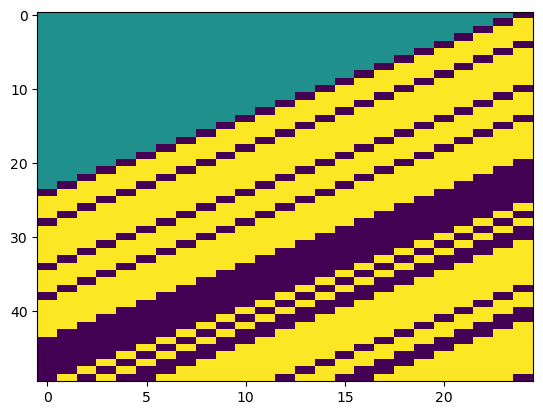

In [2]:
# Using toeplitz to get the design matrix
from scipy.linalg import toeplitz

# X: design matrix
# The first column is a constant (1), the second is s(t - 24), the third is s(t - 23), etc.
n_stim = 25
X_stim = toeplitz(stim, np.zeros(n_stim))[:, ::-1].copy()
X_const_stim = np.column_stack([np.ones_like(stim), X_stim])

plt.imshow(X_stim[:50], aspect='auto', interpolation='none')

# Variables
- **Design matrix: $X$**
    - $X$ is a matrix where each row corresponds to a time bin, and each column contains the stimulus value at a different time lag (plus a column of ones for the bias term). This matrix is used to model how past stimulus values influence the neuron's response at each time point.
- **Spike counts: $y$**
    - $y$ is a vector containing the number of spikes observed in each time bin. This is the response variable we want to model.
- **Filter weights (STA): $w$**
    - $w$ is a vector of weights (also called the spike-triggered average, or STA) that quantifies the influence of each stimulus lag (and the bias) on the neuron's firing rate. The values in $w$ tell us how much each past stimulus value contributes to the predicted spike count.
    - 예를 들면 아래 그림에서 t-4의 peak은 stimulus가 4 bin 뒤에 firing-rate를 0.5 spike 증가 시킴을 의미함 

# Linear regression
$$
y = Xw
$$

- X에 w를 곱한 것은 여러 time bin에 대한 sliding average, 즉 convolution과 같다.

$$
X = \begin{bmatrix}
1 & x_{t-24} & x_{t-23} & x_{t-22} & \cdots & x_t
\end{bmatrix}
$$

$$
w^T = [c \quad w_{24} \quad w_{23} \quad \cdots \quad w_0]
$$

$$
y = Xw = c + \sum_{k=0}^{24} x_{t-k} w_k
$$

$$
y = c + x \ast w (t)
$$

# Least squares solution
$$
w = (X^\top X)^{-1} X^\top y
$$

Text(0.5, 1.0, 'Linear-Gaussian GLM filter')

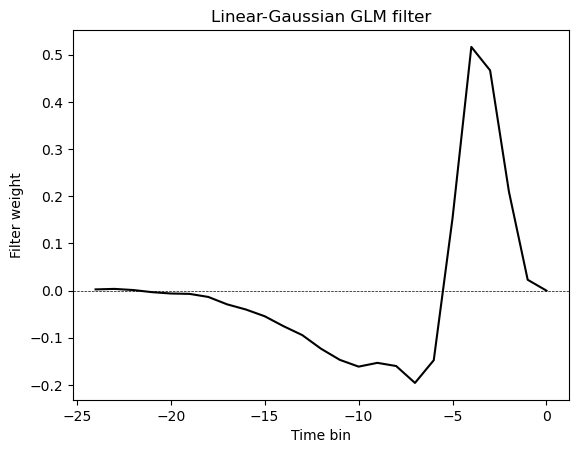

In [3]:
# Design matrix: X
# sta: w
# spike counts: y
# y = Xw
# w = (X.T @ X)^-1 @ X.T @ y
w = np.linalg.pinv(X_const_stim.T @ X_const_stim) @ X_const_stim.T @ spike_bin
t = np.arange(-n_stim + 1, 1)

plt.plot(t, w[1:], 'k')
plt.axhline(0, color='k', linewidth=0.5, linestyle='--')
plt.xlabel('Time bin')
plt.ylabel('Filter weight')
plt.title('Linear-Gaussian GLM filter')

Text(0.5, 1.0, 'Linear-Gaussian GLM prediction')

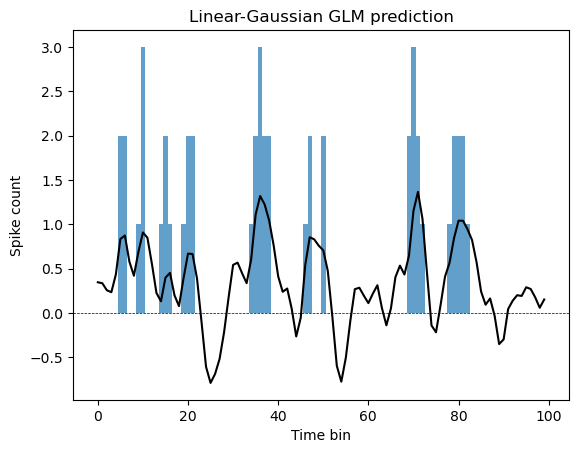

In [4]:
# Predicting spikes with a linear-Gaussian GLM
y_est = X_const_stim @ w
plt.plot(y_est[:100], 'k')
plt.bar(np.arange(100), spike_bin[:100], width=1.0, color='C0', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5, linestyle='--')
plt.xlabel('Time bin')
plt.ylabel('Spike count')
plt.title('Linear-Gaussian GLM prediction')

Time taken: 0.05 seconds


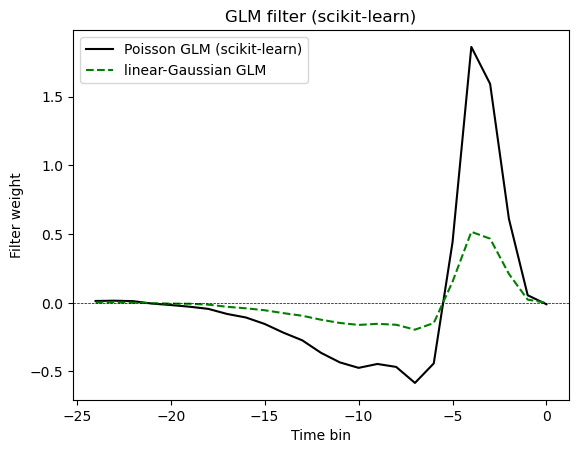

In [5]:
# Poisson regression using scikit-learn
from time import time
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor(alpha=0.0)

start = time()
model.fit(X_stim, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_sklearn = model.coef_

plt.plot(t, w_sklearn, 'k', label='Poisson GLM (scikit-learn)')
plt.plot(t, w[1:], 'g--', label='linear-Gaussian GLM')
plt.axhline(0, color='k', linewidth=0.5, linestyle='--')
plt.xlabel('Time bin')
plt.ylabel('Filter weight')
plt.title('GLM filter (scikit-learn)')
plt.legend()

Converged at 3 iterations
Time taken: 1.27 seconds
Explained deviance: 51.77%


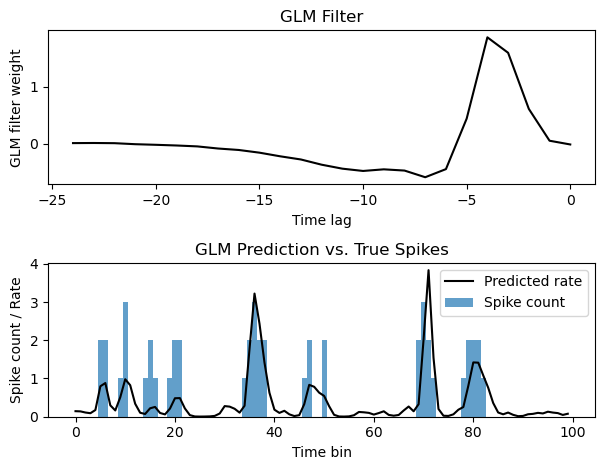

In [6]:
# Poisson regression using PyTorch
from time import time
from ephys.glm import PoissonRegressor

n_feature, n_neuron = X_stim.shape[1], 1
glm = PoissonRegressor()

start = time()
glm.fit(X_stim, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_glm = glm.coef_
y_est = glm.transform(X_stim)

plt.subplot(2, 1, 1)
plt.plot(np.arange(-n_stim + 1, 1), w_glm, 'k')
plt.xlabel('Time lag')
plt.ylabel('GLM filter weight')
plt.title('GLM Filter')

plt.subplot(2, 1, 2)
plt.plot(y_est[:100], 'k', label='Predicted rate')
plt.bar(np.arange(100), spike_bin[:100], width=1.0, color='C0', alpha=0.7, label='Spike count')
plt.xlabel('Time bin')
plt.ylabel('Spike count / Rate')
plt.title('GLM Prediction vs. True Spikes')
plt.legend()
plt.tight_layout()

print(f"Explained deviance: {glm.explained_deviance_ * 100:.2f}%")

Converged at 15 iterations
Time taken: 4.12 seconds
Explained deviance: 58.15%


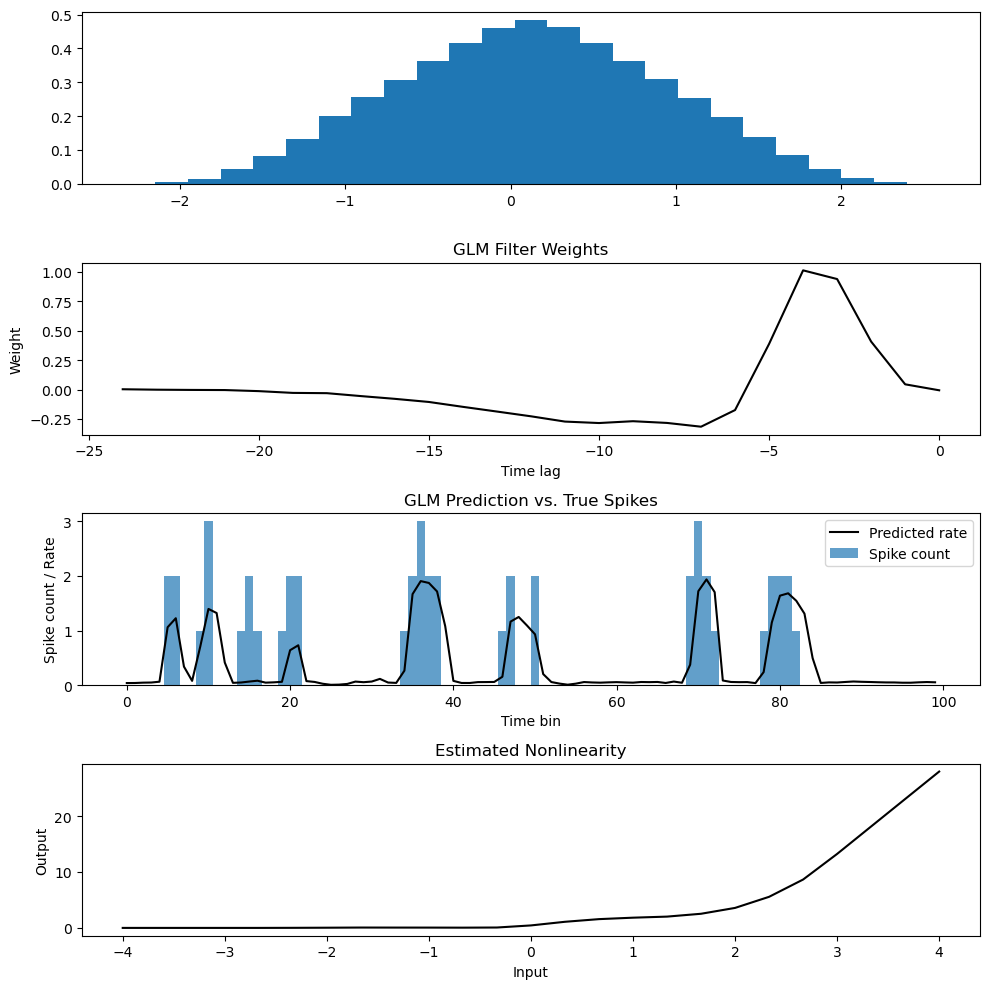

In [7]:
# Non-parametric Poisson GLM
# Link function for Poisson regression is exp(X @ w)
# Non-parametric Poisson GLM uses a non-linear activation function to model the relationship between the linear predictor and the response variable
import torch

glm = PoissonRegressor(model="Nonparametric")

start = time()
glm.fit(X_stim, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_glm = glm.coef_
y_est = glm.transform(X_stim)
x_activation, y_activation = glm.model.activation.curve

X_torch = torch.as_tensor(X_stim, dtype=torch.float32, device=glm.device)
h = glm.model.linear(X_torch).detach().cpu().numpy()

f, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].hist(h, bins=25, density=True)

axs[1].plot(np.arange(-n_stim + 1, 1), w_glm, 'k', label='GLM weights')
axs[1].set_xlabel('Time lag')
axs[1].set_ylabel('Weight')
axs[1].set_title('GLM Filter Weights')

axs[2].plot(y_est[:100], 'k', label='Predicted rate')
axs[2].bar(np.arange(100), spike_bin[:100], width=1.0, color='C0', alpha=0.7, label='Spike count')
axs[2].set_xlabel('Time bin')
axs[2].set_ylabel('Spike count / Rate')
axs[2].set_title('GLM Prediction vs. True Spikes')
axs[2].legend()

axs[3].plot(x_activation, y_activation, 'k', label='Nonlinearity')
axs[3].set_xlabel('Input')
axs[3].set_ylabel('Output')
axs[3].set_title('Estimated Nonlinearity')
plt.tight_layout()

print(f"Explained deviance: {glm.explained_deviance_ * 100:.2f}%")

Converged at 71 iterations
Time taken: 24.91 seconds
Explained deviance: 70.74%


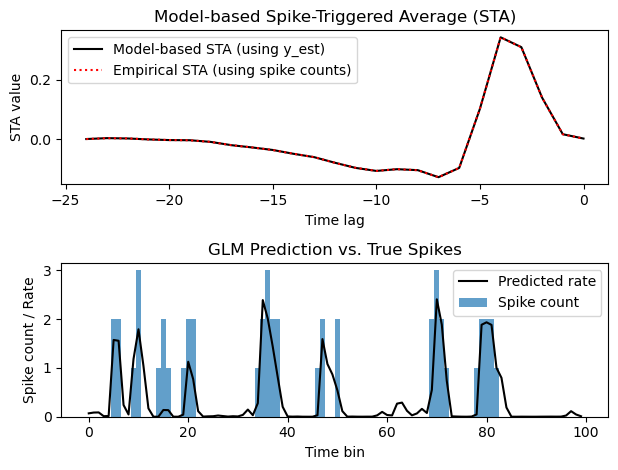

In [8]:
# Non-linear model: will take a long time to run
# But will give a better fit
from torch import nn
class NLPoissonGLM(nn.Module):
    def __init__(self, n_feature, n_neuron, hidden_size=25):
        super().__init__()
        self.linear = nn.Linear(n_feature, hidden_size)
        self.activation = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(hidden_size, n_neuron)

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        x = self.linear2(x)
        return torch.exp(x)

n_feature, n_neuron = X_stim.shape[1], 1
glm = PoissonRegressor(model=NLPoissonGLM(n_feature, n_neuron))

start = time()
glm.fit(X_stim, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_glm = glm.coef_
y_est = glm.transform(X_stim).squeeze()
sta_model = np.average(X_stim, axis=0, weights=y_est.ravel())
sta = np.average(X_stim, axis=0, weights=spike_bin)

plt.subplot(2, 1, 1)
plt.plot(np.arange(-n_stim + 1, 1), sta_model, 'k', label='Model-based STA (using y_est)')
plt.plot(np.arange(-n_stim + 1, 1), sta, "r:", label='Empirical STA (using spike counts)')
plt.xlabel('Time lag')
plt.ylabel('STA value')
plt.title('Model-based Spike-Triggered Average (STA)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_est[:100], 'k', label='Predicted rate')
plt.bar(np.arange(100), spike_bin[:100], width=1.0, color='C0', alpha=0.7, label='Spike count')
plt.xlabel('Time bin')
plt.ylabel('Spike count / Rate')
plt.title('GLM Prediction vs. True Spikes')
plt.legend()
plt.tight_layout()

print(f"Explained deviance: {glm.explained_deviance_ * 100:.2f}%")

# Negative log-likelihood of spike count 

- [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution)

- Spike count = s
- Rate = r

$$
P (s | r)  = \frac{r^s e^{-r}}{s!}
$$

$$
NLL = - log P (s | r) = - s \log r - r - \log {s!}
$$

# Deviance
- Model deviance
    - Saturated model: $r = s$
    - Null model: $r = \bar{s}$

$$
D_{model} = 2 * (NLL_{model} - NLL_{saturated})
$$

$$
D_{null} = 2 * (NLL_{null} - NLL_{saturated})
$$

# Explained deviance
$$
R^2 = 1 - \frac{D_{model}}{D_{null}}
$$

In [9]:
NLL_glm = -np.sum(spike_bin * np.log(y_est) - y_est)
NLL_0 = -np.sum(spike_bin * np.log(np.mean(spike_bin)) - np.mean(spike_bin))
NLL_sat = -np.sum(spike_bin[spike_bin != 0] * np.log(spike_bin[spike_bin != 0]) - spike_bin[spike_bin != 0])

deviance_glm = 2 * (NLL_glm - NLL_sat)
deviance_0 = 2 * (NLL_0 - NLL_sat)

explained_deviance_glm = 1 - deviance_glm / deviance_0

print(f'Explained deviance of GLM: {explained_deviance_glm * 100:.2f}%')

Explained deviance of GLM: 70.74%


## GLM with spike history
In this section, we extend the GLM to include spike history terms as additional variables.
This allows the model to capture dependencies of the neuron's firing on its own past activity (and on the activity of other neurons).

We construct a design matrix that concatenates both the stimulus history and the spike history for each neuron.
The resulting GLM can then be fit as before, and the learned filters can be interpreted as the effect of stimulus and spike history on firing probability.


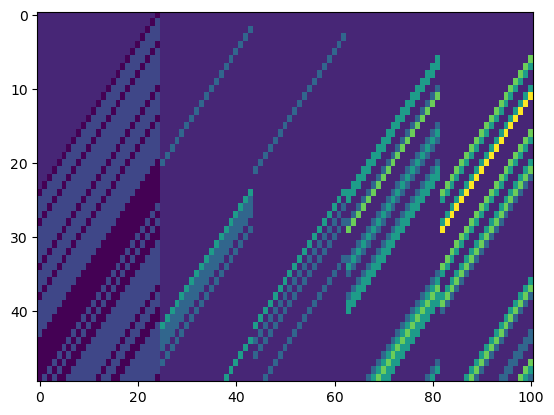

In [10]:
from scipy.linalg import toeplitz

n_neuron = len(spikes)
sps = np.array([np.histogram(s, t_bin)[0] for s in spikes])

X = []
n_stim = 25
X_stim = toeplitz(stim, np.zeros(n_stim))[:, ::-1].copy()
X.append(X_stim)

n_spike = 20
for i_neuron in range(n_neuron):
    X.append(toeplitz(sps[i_neuron], np.zeros(n_spike))[:, :0:-1])

X_stack = np.hstack(X)

plt.imshow(X_stack[:50], aspect='auto', interpolation='none')

Time taken: 1.18 seconds


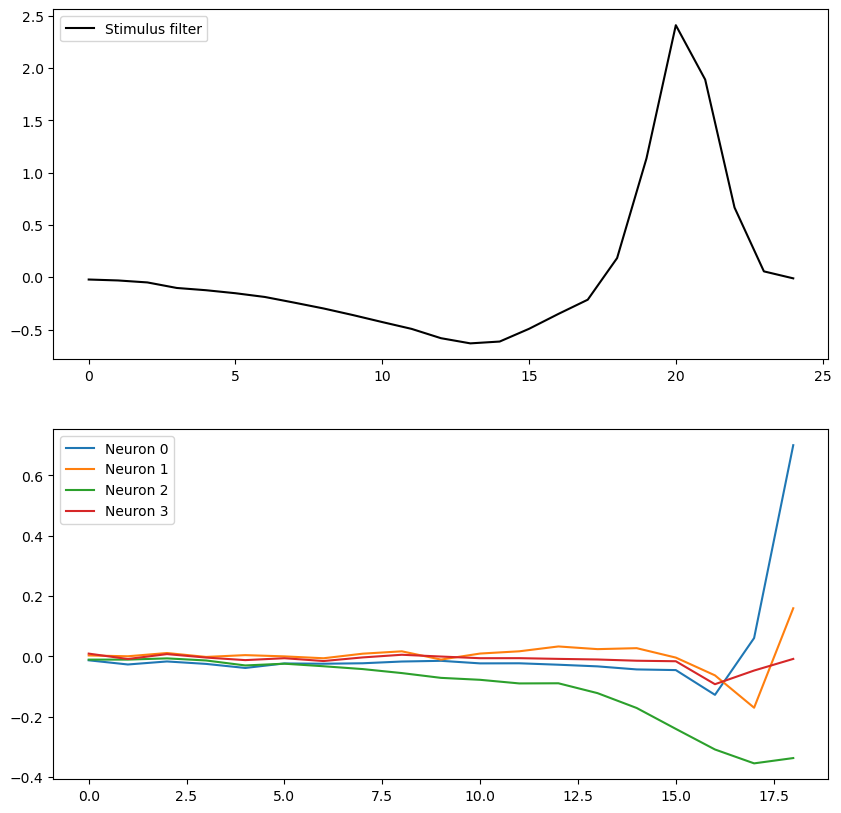

In [11]:
from time import time
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor(alpha=0.0, max_iter=100, tol=1e-6, fit_intercept=True)

start = time()
model.fit(X_stack, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')
w_glm = model.coef_

w_stim = w_glm[:n_stim]
w_spike = w_glm[n_stim:].reshape(n_neuron, -1)

f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(w_stim, 'k', label='Stimulus filter')

for i in range(n_neuron):
    axs[1].plot(w_spike[i], label=f'Neuron {i}')

axs[0].legend()
axs[1].legend()

Converged at 6 iterations
Time taken: 0.59 seconds
Explained deviance: 56.58%


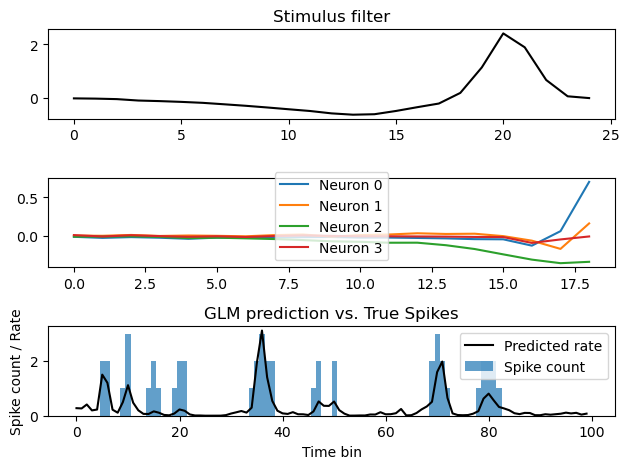

In [12]:
# For the model with many parameters, PyTorch seems faster
from ephys.glm import PoissonRegressor

model = PoissonRegressor()

start = time()
model.fit(X, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_glm = model.coef_
n_var = len(w_glm)

y_est = model.transform(X)

f, axs = plt.subplots(3, 1)
axs[0].plot(w_glm[0], 'k', label='Stimulus filter')
axs[0].set_title('Stimulus filter')

for i in range(1, n_var):
    axs[1].plot(w_glm[i], label=f'Neuron {i - 1}')
axs[1].legend()

axs[2].plot(y_est[:100], 'k', label='Predicted rate')
axs[2].bar(np.arange(100), spike_bin[:100], width=1.0, color='C0', alpha=0.7, label='Spike count')
axs[2].set_xlabel('Time bin')
axs[2].set_ylabel('Spike count / Rate')
axs[2].set_title('GLM prediction vs. True Spikes')
axs[2].legend()

plt.tight_layout()

print(f"Explained deviance: {model.explained_deviance_ * 100:.2f}%")

Converged at 25 iterations
Time taken: 8.94 seconds
Explained deviance: 63.46%


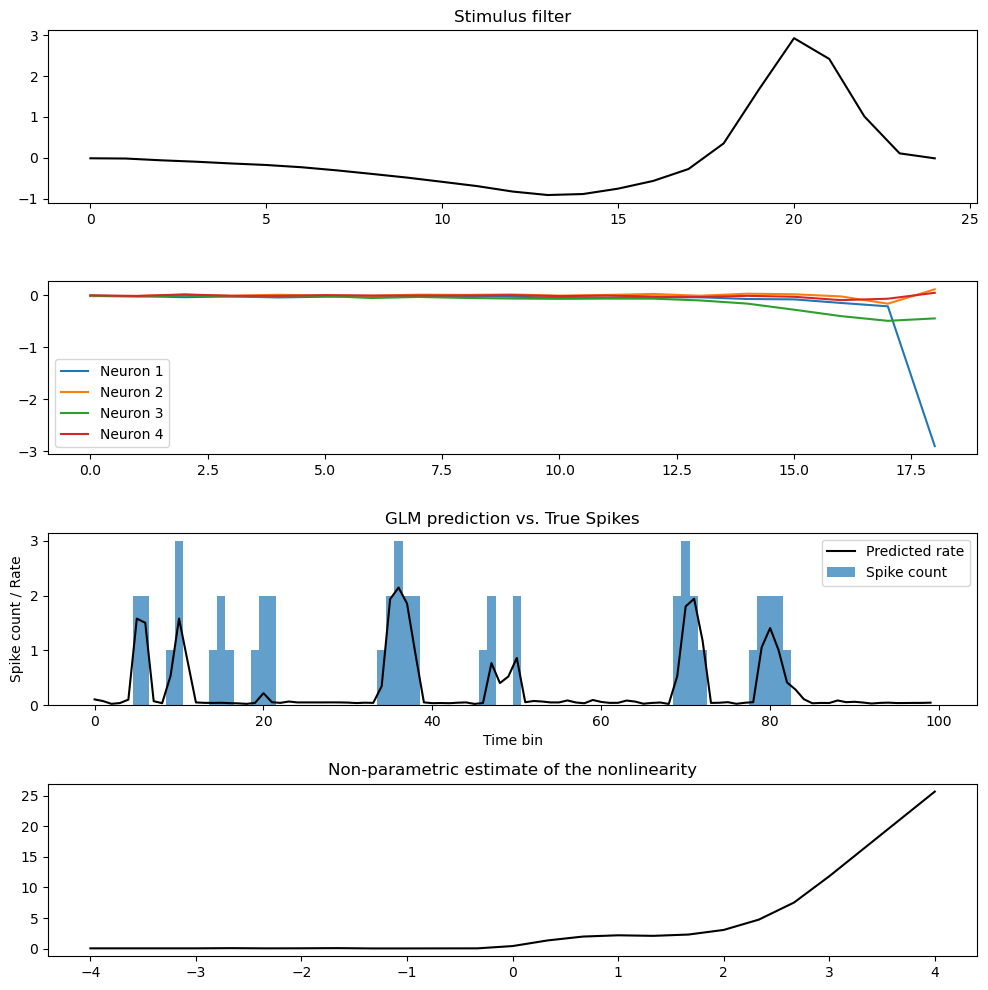

In [13]:
# For the model with many parameters, PyTorch seems faster
model = PoissonRegressor(model="Nonparametric")

start = time()
model.fit(X, spike_bin)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_glm = model.coef_
n_var = len(w_glm)

y_est = model.transform(X)
x_activation, y_activation = model.model.activation.curve

f, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].plot(w_glm[0], 'k', label='Stimulus filter')
axs[0].set_title('Stimulus filter')

for i in range(1, n_var):
    axs[1].plot(w_glm[i], label=f'Neuron {i}')
axs[1].legend()

axs[2].plot(y_est[:100], 'k', label='Predicted rate')
axs[2].bar(np.arange(100), spike_bin[:100], width=1.0, color='C0', alpha=0.7, label='Spike count')
axs[2].set_xlabel('Time bin')
axs[2].set_ylabel('Spike count / Rate')
axs[2].set_title('GLM prediction vs. True Spikes')
axs[2].legend()

axs[3].plot(x_activation, y_activation, 'k', label='Nonlinearity')
axs[3].set_title('Non-parametric estimate of the nonlinearity')

plt.tight_layout()

print(f"Explained deviance: {model.explained_deviance_ * 100:.2f}%")

# Fit multiple neurons simultaneously
- spike rate y could have multiple neurons so that fitting can happen simultaneously
    - y: (n_time_bin, n_neurons)

Converged at 4 iterations
Time taken: 0.16 seconds
Explained deviance: 56.21%


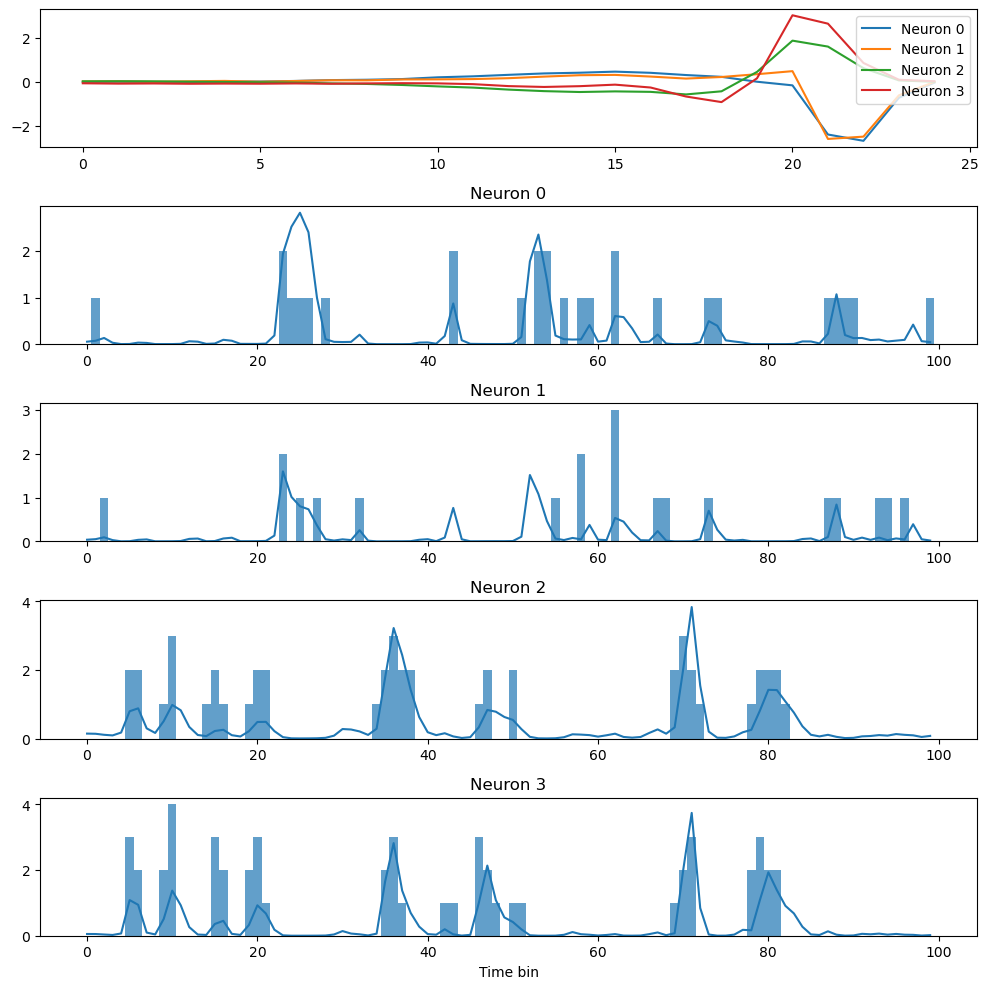

In [14]:
from time import time
from ephys.glm import PoissonRegressor

spike_bins = np.stack([np.histogram(s, t_bin)[0] for s in spikes], axis=-1)

model = PoissonRegressor()

start = time()
model.fit(X_stim, spike_bins)
end = time()
print(f'Time taken: {end - start:.2f} seconds')

w_glm = model.coef_
n_var = len(w_glm)

y_est = model.transform(X_stim)

f, axs = plt.subplots(5, 1, figsize=(10, 10))

for i in range(n_neuron):
    axs[0].plot(w_glm[i], label=f'Neuron {i}')
axs[0].legend()

for i in range(n_neuron):
    axs[i+1].plot(y_est[:100, i], label=f'Neuron {i}')
    axs[i+1].bar(np.arange(100), spike_bins[:100, i], width=1.0, color='C0', alpha=0.7, label='Spike count')
    axs[i+1].set_title(f'Neuron {i}')

axs[-1].set_xlabel('Time bin')
plt.tight_layout()

print(f"Explained deviance: {model.explained_deviance_ * 100:.2f}%")

# Performance summary
- Poisson regression (exponential link function): 51.77%
- Poisson regression (non-parametric link function): 58.15%
- Neural network: 70.74%
- Poisson regression with spike history (exponential link function): 56.58%
- Poisson regression with spike history (non-parametric link function): 63.46%